In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pytorch_wavelets
!pip install pot

import locale
tmp = locale.getpreferredencoding
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ipython-autotime
%load_ext autotime
locale.getpreferredencoding = tmp
!pip install geomloss
!pip install pykeops > install.log
!pip install pot
import geomloss

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.6 MB/s eta 0:0

In [ ]:
import numpy as np
s = np.random.get_state()
import torch
from torch import nn
import torchvision
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import ot
import time
import pickle as pkl
import random
from typing import NamedTuple, Optional, Dict, Any
from tqdm import tqdm
import pywt
# import pytorch_wavelets
from scipy.ndimage import gaussian_filter
from google.colab import drive
drive.mount('/content/drive')
import sys, os
project_path = '/content/drive/MyDrive'
sys.path.append(project_path)

from utils_torch import *

from training_params import Opt, create_training_params_from_dict



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 16.9 s (started: 2024-03-15 19:05:19 +00:00)


#### Create folders for storing results

In [ ]:
for name in ['imgs', 'models', 'hists', 'setups']:
  if not os.path.exists(f'{project_path}/{name}'):
    os.makedirs(f'{project_path}/{name}')

time: 31.4 ms (started: 2024-03-15 19:05:36 +00:00)


#### Initialize the experiment parameters

(setting to default values first, then changing the desired ones)

In [ ]:
d = Opt()._asdict()

display(d)

{'exp_id': 8728411616463629,
 'n_epochs': 300,
 'batch_size': 200,
 'epsilon': 0.0,
 'n_sinkhorn_steps': 100,
 'lr': 0.005,
 'latent_dim': 2,
 'network_architecture': {'n_hidden_gener_1': 500,
  'n_hidden_gener_2': 500,
  'n_input': 784,
  'n_z': 2},
 'sinkhorn_method': 'sinkhorn_log',
 'n_train_samples': None,
 'n_test_samples': None,
 'val_freq': 5,
 'dump_freq': 10,
 'n_display': 20,
 'debias_sinkhorn': False,
 'debias_grad_sinkhorn': False,
 'load_path': None,
 'align_noise_mean': False,
 'cost_fn': 'l2',
 'noise': 'normal',
 'data_noise': 0.0,
 'transfer_fct': 'softplus',
 'model': 'perceptron',
 'norm_clip': None,
 'use_proj': False,
 'proj_dim': 196,
 'denoise_wavelet': False,
 'data_transform': None,
 'coef_thresh': None,
 'mean_eps': 0.0,
 'approx_norm': False,
 'use_bn': False}

time: 13.9 ms (started: 2024-03-15 19:05:36 +00:00)


In [ ]:
sigma = 4.5
d['approx_norm'] = False
d['data_transform'] = None
d['norm_clip'] = 28*28
d['transfer_fct'] = 'relu'
d['data_noise'] = sigma
d['epsilon'] = sigma#2*(sigma ** 2)
d['n_sinkhorn_steps'] = 2000
d['batch_size'] = 1000#400
d['cost_fn'] = 'l1'
d['noise'] = 'laplace'#'normal'
d['dump_freq'] = 1
d['lr'] = 0.0002
d['load_path'] = None
d['val_freq'] = 5
d['dump_freq'] = 1
d['use_bn'] = False
d['exp_id'] = int(f'{np.random.rand():.16f}'[2:])
d['n_epochs'] = 300#200
d['latent_dim'] = 100
d['sinkhorn_method'] = 'sinkhorn_geomloss' #'sinkhorn_log'
# d['coef_thresh'] = 0.6
# np.random.set_state(cur_st)

time: 9.76 ms (started: 2024-03-15 19:05:36 +00:00)


In [ ]:
opt = create_training_params_from_dict(d)
opt.network_architecture['n_z'] = opt.latent_dim

model_name = f'{opt.sinkhorn_method}_{opt.n_epochs}epochs_{opt.exp_id}'
with open(f'{project_path}/setups/{model_name}.pkl', 'wb') as f:
    pkl.dump(opt._asdict(), f)
print('Training parameters:\n', opt._asdict())
print('Starting to train')


Training parameters:
 {'exp_id': 3993805182326026, 'n_epochs': 300, 'batch_size': 1000, 'epsilon': 4.5, 'n_sinkhorn_steps': 2000, 'lr': 0.0002, 'latent_dim': 100, 'network_architecture': {'n_hidden_gener_1': 500, 'n_hidden_gener_2': 500, 'n_input': 784, 'n_z': 100}, 'sinkhorn_method': 'sinkhorn_geomloss', 'n_train_samples': None, 'n_test_samples': None, 'val_freq': 5, 'dump_freq': 1, 'n_display': 20, 'debias_sinkhorn': False, 'debias_grad_sinkhorn': False, 'load_path': None, 'align_noise_mean': False, 'cost_fn': 'l1', 'noise': 'laplace', 'data_noise': 4.5, 'transfer_fct': 'relu', 'model': 'perceptron', 'norm_clip': 784, 'use_proj': False, 'proj_dim': 196, 'denoise_wavelet': False, 'data_transform': None, 'coef_thresh': None, 'mean_eps': 0.0, 'approx_norm': False, 'use_bn': False}
Starting to train
time: 35.8 ms (started: 2024-03-15 19:05:36 +00:00)


#### Create the model

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

G = Generator_DCGAN(opt.latent_dim, opt.use_bn, opt.transfer_fct)

optim = torch.optim.Adam(G.parameters(), lr=opt.lr, betas = (0.5, 0.999))

mps_device = torch.device("cuda")

time: 84.4 ms (started: 2024-03-15 19:05:36 +00:00)


Initialize the loss function

In [ ]:
if opt.sinkhorn_method == 'sinkhorn_geomloss':
  loss_args = {
      'loss': "sinkhorn",
      'cost': "Sum(Abs(X - Y))" if opt.cost_fn == 'l1' else None, # None <=> SqNorm2(X-Y)/2
      'p': 1 if opt.cost_fn == 'l1' else 2,
      'scaling': 0.9,
      'debias': False,
      'backend': 'online'
  }

  sinkhorn_geomloss = geomloss.SamplesLoss(**loss_args, blur=opt.data_noise)

  loss_fn = lambda X,Y: sinkhorn_geomloss(X.view(X.shape[0], -1),Y.view(Y.shape[0], -1))
else:
  loss_fn = lambda X,Y: sinkhorn_loss(X.view(X.shape[0], -1),Y.view(Y.shape[0], -1),
                                    opt.sinkhorn_method, opt.epsilon, debiased=opt.debias_sinkhorn,
                                    dist=opt.cost_fn, n_sinkhorn_steps=opt.n_sinkhorn_steps, batch_size=opt.batch_size)
transform_fn = lambda X: X
val_loss_fn = lambda X,Y: sinkhorn_loss(X.view(X.shape[0], -1),Y.view(Y.shape[0], -1),
                                        'emd', 0.0, debiased=False, dist=opt.cost_fn,
                                        n_sinkhorn_steps=100, batch_size=opt.batch_size)

#### Add the noise and apply the transforms specified by the setup parameters

In [ ]:
train_ds = get_dataset(n_data=opt.n_train_samples).reshape(-1, 28*28)
train_ds_orig = get_dataset(n_data=opt.n_train_samples).reshape(-1, 28*28)
test_ds = get_dataset(train=False, n_data=opt.n_test_samples).reshape(-1, 28*28)

if opt.load_path is not None:
    checkpoint = torch.load(opt.load_path)
    if 'model_state_dict' in checkpoint:
        G.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        G.load_state_dict(checkpoint)
    G.to(mps_device)
    for state in optim.state.values():
        for k, v in state.items():
            state[k] = v.to(mps_device)

if opt.mean_eps>0:
    avg_est = calculate_mean_privatly(train_ds.reshape(train_ds.shape[0], -1).numpy(),
                          eps = 1, p=0.5, maxnorm=28)[:-1]
    avg_est = 1.1 * gaussian_filter(avg_est.reshape(28,28), sigma=1.2).reshape(-1)
    avg_est = np.clip(avg_est * 28, -1, 1)
else:
    avg_est = -np.ones(28*28)

if opt.data_transform == 'wavelet':
    n_img = train_ds.shape[0]
    wavelets = [pywt.wavedec2(train_ds[i].numpy().reshape(28,28), wavelet='db1', level=3, mode='zero')
                for i in range(n_img)]
    coeff_array, coeff_slices = list(zip(*list(map(lambda x: pywt.coeffs_to_array(x), wavelets))))
    train_ds = np.concatenate(coeff_array).reshape(n_img, -1)
    wavelet_transform = pytorch_wavelets.DWTForward(J=3, mode='zero', wave='db1')
    transform_fn = lambda X: get_coeff_array(*wavelet_transform(X.reshape(-1, 1, 28, 28))).reshape(X.shape[0],-1)
    avg_est = pywt.coeffs_to_array(pywt.wavedec2(avg_est.reshape(28,28), wavelet='db1', level=3, mode='zero'))[0]
    avg_est = avg_est.reshape(-1)
elif opt.data_transform == 'dct':
    dct_matrix = get_dct_matrix_transposed(28).float()
    train_ds = torch.matmul(train_ds.view(train_ds.shape[0], -1), dct_matrix).numpy()
    transform_fn = lambda X: torch.matmul(X, dct_matrix.to(X.device))
    avg_est = dct_matrix.T.numpy().dot(avg_est.reshape(-1))
elif opt.data_transform is not None:
    raise ValueError('Unknown data transform')


if opt.data_transform is not None and opt.coef_thresh is not None:
    train_ds -= avg_est
    coeff_array_abs_sorted = np.sort(np.abs(train_ds), axis = -1)
    thresh = 1-opt.coef_thresh
    print(thresh)
    tresh_per_img = coeff_array_abs_sorted[:, -np.ceil(thresh*coeff_array_abs_sorted.shape[1]).astype(int)]
    train_ds = (np.abs(train_ds) >= np.expand_dims(tresh_per_img, -1)) * train_ds
    train_ds += avg_est
    print(tresh_per_img)

if type(train_ds) == np.ndarray:
    train_ds = torch.tensor(train_ds).float()

if opt.use_proj:
    permutation = np.random.permutation(len(data_source))
    # Always drop the last batch
    permutation = permutation[:-len(train_ds)%opt.batch_size]
    batches = train_ds[permutation].reshape(-1, opt.batch_size, *train_ds.shape[1:])
    mat_list = [generate_rnd_matrix(28*28, opt.proj_dim)[0] for _ in range(train_ds.shape[0]//opt.batch_size)]
    batch_mat_tuples = []
    for i in range(len(mat_list)):
        batch = torch.matmul(batches[i], mat_list[i])
        if opt.norm_clip is not None:
            batch = clip_norm(batch, opt.norm_clip, norm_p=1 if opt.cost_fn == 'l1' else 2)
        batch = add_noise_tensor_transform(batch, noise=opt.noise, noise_scale=opt.data_noise, clip=False)
        batch_mat_tuples.append((batch, mat_list[i]))
    train_ds = batch_mat_tuples
    loss_fn = lambda X,Y: loss_fn(
        torch.matmul(X, torch.Tensor(Y[1])), Y[0])
else:
    if opt.norm_clip is not None:
        train_ds = clip_norm(train_ds-avg_est, opt.norm_clip, norm_p=1 if opt.cost_fn == 'l1' else 2,
                              approx=opt.approx_norm, avg=0) + avg_est
        # train_ds += np.expand_dims(avg_est, 0)

        if type(train_ds) == np.ndarray:
            train_ds = torch.tensor(train_ds).float()
    train_ds = add_noise_tensor_transform(train_ds, noise=opt.noise,
                                      noise_scale=opt.data_noise, clip=False)
    if opt.denoise_wavelet:
        train_ds = denoise_fn(train_ds, sigma=opt.data_noise, wt='db1', level=3, noise=opt.noise).detach()
loss_fn_with_transform = lambda X, Y: loss_fn(transform_fn(X), Y)


train_ds = MyDataset(train_ds.float(), opt.batch_size, opt.use_proj)
test_ds = MyDataset(test_ds.float(), opt.batch_size, False)




100%|██████████| 9912422/9912422 [00:00<00:00, 204164798.54it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38987992.86it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53214719.66it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21947613.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

time: 8.19 s (started: 2024-03-15 19:05:37 +00:00)


Reconstructed image pixel values in:  -21.284079 18.19173
The norm of the image:  3463.7658313065767


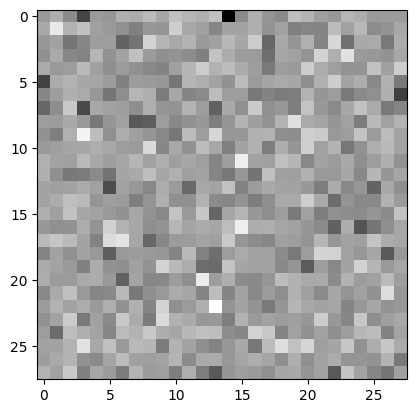

time: 636 ms (started: 2024-03-15 19:05:45 +00:00)


In [ ]:
import PIL
idx = 15
print('Reconstructed image pixel values in: ', np.min(torch.matmul(train_ds.data_source[idx], get_dct_matrix_transposed(28).T).reshape(28,28).detach().numpy()),
      np.max(torch.matmul(train_ds.data_source[idx], get_dct_matrix_transposed(28).T).reshape(28,28).detach().numpy()))
print('The norm of the image: ', np.linalg.norm(train_ds.data_source[idx].detach().numpy()-avg_est, ord = 1))
%matplotlib inline
img_rec = train_ds.data_source[idx].reshape(28,28,).detach().numpy()
#torch.matmul(train_ds.data_source[idx], get_dct_matrix_transposed(28).T).reshape(28,28).detach().numpy()
# img_rec[0,0] = -1
# img_rec[0,1] = 1
# img_rec = np.clip(img_rec, -1, 1)
img_rec -= (img_rec).min()
img_rec /=(img_rec).max()
img_rec *= 255
img_rec = np.round(img_rec, 0).astype(np.uint8)
plt.imshow(img_rec, cmap = 'gray')
plt.show()
im = PIL.Image.fromarray(img_rec)

15
Reconstructed image pixel values in:  -1195.5889 3671.5452
The norm of the image:  125291.98319244385


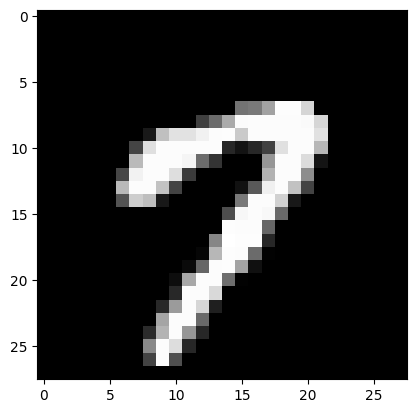

time: 391 ms (started: 2024-03-15 19:05:46 +00:00)


In [ ]:
for idx in [15]:#range(20):
  print(idx)
  print('Reconstructed image pixel values in: ', np.min(torch.matmul(train_ds.data_source[idx], get_dct_matrix_transposed(28).T).reshape(28,28).detach().numpy()),
        np.max(torch.matmul(train_ds.data_source[idx], get_dct_matrix_transposed(28).T).reshape(28,28).detach().numpy()))
  print('The norm of the image: ', np.linalg.norm(train_ds.data_source[idx].detach().numpy()-avg_est, ord = 1))
  %matplotlib inline
  img_rec = train_ds_orig[idx].reshape(28,28,).detach().numpy()
  #torch.matmul(train_ds.data_source[idx], get_dct_matrix_transposed(28).T).reshape(28,28).detach().numpy()
  # img_rec[0,0] = -1
  # img_rec[0,1] = 1
  # img_rec = np.clip(img_rec, -1, 1)
  plt.imshow(img_rec, cmap = 'gray')
  plt.show()

#### Training

In [ ]:
out = train(G, optim, loss_fn_with_transform, train_ds, test_ds, val_loss_fn=val_loss_fn, epochs = opt.n_epochs,
            n_display = opt.n_display, random_noise_generator = lambda x: torch.rand(x, opt.latent_dim, 1, 1), device=mps_device,
            val_freq=opt.val_freq, dump_freq=opt.dump_freq, model_name=model_name)
print('Training finished. Weeeee')

  0%|          | 0/60 [00:00<?, ?it/s]

[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [c-d*Sum(Abs(a-b)),1] with a=Var(0,784,0), b=Var(1,784,1), c=Var(2,1,1), d=Var(3,1,2) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -((Sign(a-b)*(d*Extract(e,1,1)))*Exp((c-d*Sum(Abs(a-b)))-Extract(f,0,1))) with a=Var(0,784,0), b=Var(1,784,1), c=Var(2,1,1), d=Var(3,1,2), e=Var(4,2,0), f=Var(5,2,0) ... OK


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


Epoch 1: Loss = 3567.08251953125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 2: Loss = 3559.70703125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 3: Loss = 3559.1123046875 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 4: Loss = 3558.9169921875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Epoch 5: Loss = 3558.56982421875 Val Loss = 73.37763977050781


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 6: Loss = 3557.8427734375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 7: Loss = 3556.8134765625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 8: Loss = 3555.19580078125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 9: Loss = 3553.791259765625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 10: Loss = 3552.88134765625 Val Loss = 77.9920425415039


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 11: Loss = 3552.558349609375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 12: Loss = 3552.312744140625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 13: Loss = 3552.075927734375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 14: Loss = 3551.62109375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 15: Loss = 3549.928955078125 Val Loss = 74.75334167480469


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 16: Loss = 3549.596435546875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 17: Loss = 3549.433837890625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 18: Loss = 3549.403076171875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 19: Loss = 3549.315185546875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 20: Loss = 3549.31494140625 Val Loss = 71.20883178710938


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 21: Loss = 3549.27294921875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 22: Loss = 3549.210693359375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 23: Loss = 3549.222900390625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 24: Loss = 3549.186767578125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 25: Loss = 3549.169921875 Val Loss = 71.23035430908203


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 26: Loss = 3549.1474609375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 27: Loss = 3549.125244140625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 28: Loss = 3549.113525390625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 29: Loss = 3549.09765625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 30: Loss = 3549.083251953125 Val Loss = 70.66495513916016


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 31: Loss = 3549.0439453125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 32: Loss = 3549.048583984375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 33: Loss = 3549.0048828125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 34: Loss = 3549.01123046875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 35: Loss = 3549.003662109375 Val Loss = 71.02305603027344


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 36: Loss = 3548.977783203125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 37: Loss = 3548.9814453125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 38: Loss = 3548.97216796875 


100%|██████████| 60/60 [01:13<00:00,  1.22s/it]


Epoch 39: Loss = 3548.953125 


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 40: Loss = 3548.959716796875 Val Loss = 70.12185668945312


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 41: Loss = 3548.933837890625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 42: Loss = 3548.91015625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 43: Loss = 3548.91748046875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 44: Loss = 3548.90185546875 


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 45: Loss = 3548.896484375 Val Loss = 70.13111114501953


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 46: Loss = 3548.896728515625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 47: Loss = 3548.873046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 48: Loss = 3548.871826171875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 49: Loss = 3548.86279296875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 50: Loss = 3548.8623046875 Val Loss = 71.5530014038086


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 51: Loss = 3548.83935546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 52: Loss = 3548.845458984375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 53: Loss = 3548.83349609375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 54: Loss = 3548.815673828125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 55: Loss = 3548.8212890625 Val Loss = 70.48509979248047


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 56: Loss = 3548.81298828125 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 57: Loss = 3548.8056640625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 58: Loss = 3548.789306640625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 59: Loss = 3548.779541015625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 60: Loss = 3548.783203125 Val Loss = 69.7265625


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 61: Loss = 3548.786376953125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 62: Loss = 3548.77734375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 63: Loss = 3548.767578125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 64: Loss = 3548.75830078125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 65: Loss = 3548.758056640625 Val Loss = 69.19085693359375


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 66: Loss = 3548.742431640625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 67: Loss = 3548.734130859375 


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 68: Loss = 3548.740478515625 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 69: Loss = 3548.724853515625 


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 70: Loss = 3548.728271484375 Val Loss = 69.03347778320312


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 71: Loss = 3548.730712890625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 72: Loss = 3548.72119140625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 73: Loss = 3548.705078125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 74: Loss = 3548.7060546875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 75: Loss = 3548.705322265625 Val Loss = 70.0505142211914


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 76: Loss = 3548.7060546875 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 77: Loss = 3548.68994140625 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 78: Loss = 3548.685302734375 


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 79: Loss = 3548.668701171875 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 80: Loss = 3548.679443359375 Val Loss = 71.31383514404297


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 81: Loss = 3548.67919921875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 82: Loss = 3548.666259765625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 83: Loss = 3548.66796875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 84: Loss = 3548.660888671875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 85: Loss = 3548.660888671875 Val Loss = 71.25614166259766


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 86: Loss = 3548.670654296875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 87: Loss = 3548.6484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 88: Loss = 3548.62939453125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 89: Loss = 3548.63330078125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 90: Loss = 3548.62060546875 Val Loss = 69.87983703613281


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 91: Loss = 3548.633544921875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 92: Loss = 3548.6171875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 93: Loss = 3548.62255859375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 94: Loss = 3548.618896484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 95: Loss = 3548.62548828125 Val Loss = 69.78308868408203


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 96: Loss = 3548.62646484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 97: Loss = 3548.60546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 98: Loss = 3548.605224609375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 99: Loss = 3548.60009765625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 100: Loss = 3548.5986328125 Val Loss = 69.34030151367188


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 101: Loss = 3548.589111328125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 102: Loss = 3548.594970703125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 103: Loss = 3548.5712890625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 104: Loss = 3548.58154296875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 105: Loss = 3548.591552734375 Val Loss = 69.25886535644531


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 106: Loss = 3548.553955078125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 107: Loss = 3548.5595703125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 108: Loss = 3548.556640625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 109: Loss = 3548.56201171875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 110: Loss = 3548.5556640625 Val Loss = 70.4079818725586


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 111: Loss = 3548.55615234375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 112: Loss = 3548.55078125 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 113: Loss = 3548.556640625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 114: Loss = 3548.5595703125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 115: Loss = 3548.52783203125 Val Loss = 69.77362823486328


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 116: Loss = 3548.531005859375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 117: Loss = 3548.53759765625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 118: Loss = 3548.536376953125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 119: Loss = 3548.530029296875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 120: Loss = 3548.49462890625 Val Loss = 70.88106536865234


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 121: Loss = 3548.52197265625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 122: Loss = 3548.510009765625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 123: Loss = 3548.51416015625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 124: Loss = 3548.510498046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 125: Loss = 3548.502197265625 Val Loss = 70.05702209472656


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 126: Loss = 3548.498046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 127: Loss = 3548.49072265625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 128: Loss = 3548.49609375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 129: Loss = 3548.49658203125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 130: Loss = 3548.485595703125 Val Loss = 69.95529174804688


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 131: Loss = 3548.47705078125 


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 132: Loss = 3548.47998046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 133: Loss = 3548.4736328125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 134: Loss = 3548.4697265625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 135: Loss = 3548.477783203125 Val Loss = 70.49177551269531


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 136: Loss = 3548.457763671875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 137: Loss = 3548.482177734375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 138: Loss = 3548.471923828125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 139: Loss = 3548.449951171875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 140: Loss = 3548.458984375 Val Loss = 70.5184097290039


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 141: Loss = 3548.455078125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 142: Loss = 3548.457763671875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 143: Loss = 3548.44287109375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 144: Loss = 3548.4482421875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 145: Loss = 3548.448974609375 Val Loss = 70.8697509765625


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 146: Loss = 3548.42919921875 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 147: Loss = 3548.4248046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 148: Loss = 3548.429443359375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 149: Loss = 3548.432373046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 150: Loss = 3548.42529296875 Val Loss = 69.83399200439453


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 151: Loss = 3548.424560546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 152: Loss = 3548.417724609375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 153: Loss = 3548.423828125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 154: Loss = 3548.421630859375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 155: Loss = 3548.418701171875 Val Loss = 70.59806823730469


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 156: Loss = 3548.4208984375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 157: Loss = 3548.398681640625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 158: Loss = 3548.39697265625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 159: Loss = 3548.39794921875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 160: Loss = 3548.39697265625 Val Loss = 69.80599975585938


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 161: Loss = 3548.401123046875 


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch 162: Loss = 3548.390380859375 


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch 163: Loss = 3548.3828125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 164: Loss = 3548.3984375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 165: Loss = 3548.372802734375 Val Loss = 71.39458465576172


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 166: Loss = 3548.368896484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 167: Loss = 3548.372802734375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 168: Loss = 3548.3525390625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 169: Loss = 3548.378662109375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 170: Loss = 3548.358642578125 Val Loss = 71.19646453857422


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 171: Loss = 3548.3857421875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 172: Loss = 3548.369384765625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 173: Loss = 3548.345458984375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 174: Loss = 3548.374267578125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 175: Loss = 3548.344970703125 Val Loss = 71.90032196044922


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 176: Loss = 3548.349365234375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 177: Loss = 3548.34326171875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 178: Loss = 3548.340087890625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 179: Loss = 3548.337646484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 180: Loss = 3548.330322265625 Val Loss = 71.63627624511719


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 181: Loss = 3548.34130859375 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 182: Loss = 3548.333984375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 183: Loss = 3548.34521484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 184: Loss = 3548.326171875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 185: Loss = 3548.305908203125 Val Loss = 71.24472045898438


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 186: Loss = 3548.343505859375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 187: Loss = 3548.318115234375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 188: Loss = 3548.322021484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 189: Loss = 3548.31005859375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 190: Loss = 3548.303466796875 Val Loss = 71.07211303710938


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 191: Loss = 3548.304443359375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 192: Loss = 3548.30908203125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 193: Loss = 3548.306884765625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 194: Loss = 3548.3046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 195: Loss = 3548.2998046875 Val Loss = 72.29112243652344


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 196: Loss = 3548.294677734375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 197: Loss = 3548.283203125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 198: Loss = 3548.286376953125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 199: Loss = 3548.295166015625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 200: Loss = 3548.2978515625 Val Loss = 71.40042114257812


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 201: Loss = 3548.2861328125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 202: Loss = 3548.285888671875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 203: Loss = 3548.296875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 204: Loss = 3548.283935546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 205: Loss = 3548.27587890625 Val Loss = 70.69110870361328


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 206: Loss = 3548.26416015625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 207: Loss = 3548.27685546875 


100%|██████████| 60/60 [01:11<00:00,  1.18s/it]


Epoch 208: Loss = 3548.256103515625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 209: Loss = 3548.27294921875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 210: Loss = 3548.270751953125 Val Loss = 71.70159149169922


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 211: Loss = 3548.251953125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 212: Loss = 3548.2548828125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 213: Loss = 3548.27001953125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 214: Loss = 3548.2470703125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 215: Loss = 3548.238525390625 Val Loss = 71.84793090820312


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 216: Loss = 3548.242919921875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 217: Loss = 3548.22998046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 218: Loss = 3548.249267578125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 219: Loss = 3548.23486328125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 220: Loss = 3548.236083984375 Val Loss = 71.11051177978516


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 221: Loss = 3548.23876953125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 222: Loss = 3548.232666015625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 223: Loss = 3548.22802734375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 224: Loss = 3548.235107421875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 225: Loss = 3548.22802734375 Val Loss = 71.96623992919922


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 226: Loss = 3548.2265625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 227: Loss = 3548.226318359375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 228: Loss = 3548.21484375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 229: Loss = 3548.217041015625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 230: Loss = 3548.203369140625 Val Loss = 72.42758178710938


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 231: Loss = 3548.21435546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 232: Loss = 3548.210205078125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 233: Loss = 3548.2060546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 234: Loss = 3548.19580078125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 235: Loss = 3548.203369140625 Val Loss = 70.9764404296875


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 236: Loss = 3548.189697265625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 237: Loss = 3548.190185546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 238: Loss = 3548.1923828125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 239: Loss = 3548.18701171875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 240: Loss = 3548.193359375 Val Loss = 72.9302978515625


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 241: Loss = 3548.196533203125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 242: Loss = 3548.19873046875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 243: Loss = 3548.1962890625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 244: Loss = 3548.177001953125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 245: Loss = 3548.188232421875 Val Loss = 71.9000244140625


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 246: Loss = 3548.168212890625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 247: Loss = 3548.191650390625 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 248: Loss = 3548.171630859375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 249: Loss = 3548.17529296875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 250: Loss = 3548.169921875 Val Loss = 71.79061126708984


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 251: Loss = 3548.1611328125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 252: Loss = 3548.172607421875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 253: Loss = 3548.16845703125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 254: Loss = 3548.1640625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 255: Loss = 3548.166015625 Val Loss = 71.9126205444336


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 256: Loss = 3548.165283203125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 257: Loss = 3548.156982421875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 258: Loss = 3548.1455078125 


100%|██████████| 60/60 [01:11<00:00,  1.20s/it]


Epoch 259: Loss = 3548.150390625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 260: Loss = 3548.143798828125 Val Loss = 71.7145767211914


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 261: Loss = 3548.1474609375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 262: Loss = 3548.140869140625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 263: Loss = 3548.134033203125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 264: Loss = 3548.1455078125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 265: Loss = 3548.14599609375 Val Loss = 71.75618743896484


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 266: Loss = 3548.127685546875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 267: Loss = 3548.133056640625 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 268: Loss = 3548.12255859375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 269: Loss = 3548.122314453125 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 270: Loss = 3548.12255859375 Val Loss = 71.32756805419922


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 271: Loss = 3548.13037109375 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 272: Loss = 3548.12841796875 


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch 273: Loss = 3548.12353515625 


 28%|██▊       | 17/60 [00:20<00:51,  1.19s/it]